In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# !pip install spektral

In [6]:
import gc, numpy as np, pickle
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Bidirectional, GRU, Masking, Dense, Dropout, TimeDistributed, Lambda, Activation, dot, multiply, concatenate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import sklearn
from keras.utils import to_categorical

from sklearn.metrics.pairwise import cosine_similarity
# from spektral.layers import GCNConv, GlobalSumPool, GraphSageConv,TAGConv
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Nadam,Adam
# from tensorflow.keras.optimizers.experimental import Adagrad

In [7]:
def featuresExtraction():
    global train_text, train_audio, train_video, train_label, train_mask
    global val_text, val_audio, val_video, val_label, val_mask
    global test_text, test_audio, test_video, test_label, test_mask
    global max_segment_len

    text          = np.load('/content/drive/MyDrive/EMNLP-18-MMMU-BA-master/MOSEI/text.npz',mmap_mode='r')
    audio         = np.load('/content/drive/MyDrive/EMNLP-18-MMMU-BA-master/MOSEI/audio.npz',mmap_mode='r')
    video         = np.load('/content/drive/MyDrive/EMNLP-18-MMMU-BA-master/MOSEI/video.npz',mmap_mode='r')

    train_text    = text['train_data']
    train_audio   = audio['train_data']
    train_video   = video['train_data']

    val_text    = text['valid_data']
    val_audio   = audio['valid_data']
    val_video   = video['valid_data']

    test_text     = text['test_data']
    test_audio    = audio['test_data']
    test_video    = video['test_data']

    train_label   = video['trainSentiLabel']
    train_label   = to_categorical(train_label>=0)
    val_label   = video['validSentiLabel']
    val_label   = to_categorical(val_label>=0)
    test_label    = video['testSentiLabel']
    test_label    = to_categorical(test_label>=0)

    train_length  = video['train_length']
    val_length  = video['valid_length']
    test_length   = video['test_length']

    max_segment_len = train_text.shape[1]

    train_mask = np.zeros((train_video.shape[0], train_video.shape[1]), dtype='float')
    val_mask = np.zeros((val_video.shape[0], val_video.shape[1]), dtype='float')
    test_mask  = np.zeros((test_video.shape[0], test_video.shape[1]), dtype='float')

    for i in range(len(train_length)):
        train_mask[i,:train_length[i]]=1.0

    for i in range(len(val_length)):
        val_mask[i,:val_length[i]]=1.0

    for i in range(len(test_length)):
        test_mask[i,:test_length[i]]=1.0


In [8]:
featuresExtraction()

In [9]:
# (train_text, train_label_1,val_text,val_label_1, test_text, test_label_1, max_utt_len, train_mask,val_mask,test_mask,_,_,_) = pickle.load(open('/content/drive/MyDrive/DATASETs/mosei/text_3way.pickle', 'rb'),encoding = 'latin')
# (train_audio, _,val_audio,_, test_audio, _, _, _, _,_,_,_,_) = pickle.load(open('/content/drive/MyDrive/DATASETs/mosei/audio_3way.pickle', 'rb'),encoding = 'latin')
# (train_video, _,val_video,_, test_video, _, _, _, _,_,_,_,_) = pickle.load(open('/content/drive/MyDrive/DATASETs/mosei/video_3way.pickle', 'rb'),encoding = 'latin')

In [10]:
# 0 - train_emb
# 1 - train_label
# 2 - val_embedding
# 3 - val_label
# 4 - test_emb
# 5 - test_label
# 6 - max_len
# 7 - train_mask
# 8 - val_mask
# 9 - test_mask

In [11]:
train_text2 = np.zeros((16217,300))
test_text2 = np.zeros((4625,300))
val_text2 = np.zeros((1835,300))
train_audio2 = np.zeros((16217,74))
test_audio2 = np.zeros((4625,74))
val_audio2 = np.zeros((1835,74))
train_video2 = np.zeros((16217,35))
test_video2 = np.zeros((4625,35))
val_video2 = np.zeros((1835,35))

train_label_1 = np.zeros(16217)
test_label_1 = np.zeros(4625)
val_label_1 = np.zeros(1835)

n=0
index = 0
count = 0;
for i in range(2250):
  for j in range(98):
    if(train_mask[i][j] == 0):
      break
    train_text2[n] = train_text[i][j]
    train_audio2[n] = train_audio[i][j]
    train_video2[n] = train_video[i][j]
    for k in range(3):
      if(train_label[i][j][1] == 1):
        train_label_1[n] = 1;
    n+=1
print(n)

n=0
index = 0
for i in range(300):
  for j in range(98):
    if(val_mask[i][j] == 0):
      break
    val_text2[n] = val_text[i][j]
    val_audio2[n] = val_audio[i][j]
    val_video2[n] = val_video[i][j]
    for k in range(3):
      if(val_label[i][j][1] == 1):
        val_label_1[n] = 1;
    n+=1
print(n)

n=0
index = 0
for i in range(678):
  for j in range(98):
    if(test_mask[i][j] == 0):
      break
    test_text2[n] = test_text[i][j]
    test_audio2[n] = test_audio[i][j]
    test_video2[n] = test_video[i][j]
    for k in range(3):
      if(test_label[i][j][1] == 1):
        test_label_1[n] = 1;
    n+=1
print(n)
del train_text,train_audio,train_video,test_text,test_audio,test_video,val_text,val_audio,val_video
train_text = train_text2
train_audio = train_audio2
train_video = train_video2

val_text = val_text2
val_audio = val_audio2
val_video = val_video2

test_text = test_text2
test_audio = test_audio2
test_video = test_video2

del train_text2,train_audio2,train_video2,val_text2,val_audio2,val_video2,test_text2,test_audio2,test_video2,train_label,test_label

16217
1835
4625


In [12]:
print(train_text.shape)
print(val_text.shape)
print(test_text.shape)

(16217, 300)
(1835, 300)
(4625, 300)


In [13]:
print(sum(train_label_1))

11499.0


In [14]:
count=0
n=0
train_label = np.zeros((4718*2))
train_audio_3 = np.zeros((4718*2,74))
train_text_3 = np.zeros((4718*2,300))
train_video_3 = np.zeros((4718*2,35))
for i in range(16217):
  if(count == 4718 and train_label_1[i] == 1):
    continue;
  train_text_3[n] = train_text[i]
  train_audio_3[n] = train_audio[i]
  train_video_3[n] = train_video[i]
  if(train_label_1[i] == 1):
    count+=1
  train_label[n] = train_label_1[i]
  n+=1;
del train_text,train_audio,train_video
train_text = train_text_3
train_audio = train_audio_3
train_video = train_video_3

In [15]:
sum(train_label)

4718.0

In [16]:
train_len = 4718*2
test_len = 4625
val_len = 1835

In [17]:
def bi_modal_attention(x, y):

    '''
    .  stands for dot product
    *  stands for elemwise multiplication
    {} stands for concatenation

    m1 = x . transpose(y) ||  m2 = y . transpose(x)
    n1 = softmax(m1)      ||  n2 = softmax(m2)
    o1 = n1 . y           ||  o2 = m2 . x
    a1 = o1 * x           ||  a2 = o2 * y

    return {a1, a2}

    '''

    m1 = dot([x, y], axes=[2, 2])
    n1 = Activation('softmax')(m1)
    o1 = dot([n1, y], axes=[2, 1])
    a1 = multiply([o1, x])

    m2 = dot([y, x], axes=[2, 2])
    n2 = Activation('softmax')(m2)
    o2 = dot([n2, x], axes=[2, 1])
    a2 = multiply([o2, y])

    return concatenate([a1, a2])


In [18]:

def self_attention(x):

    '''
    .  stands for dot product
    *  stands for elemwise multiplication

    m = x . transpose(x)
    n = softmax(m)
    o = n . x
    a = o * x

    return a

    '''

    m = dot([x, x], axes=[2,2])
    n = Activation('softmax')(m)
    o = dot([n, x], axes=[2,1])
    a = multiply([o, x])

    return a

In [19]:
train_text = train_text_3.reshape(train_len,1,300)
train_audio = train_audio_3.reshape(train_len,1,74)
train_video = train_video_3.reshape(train_len,1,35)
# train_label = train_label.reshape(train_len,1,3)


test_text = test_text.reshape(test_len,1,300)
test_audio = test_audio.reshape(test_len,1,74)
test_video = test_video.reshape(test_len,1,35)
# test_label = test_label.reshape(test_len,1,3)


val_text = val_text.reshape(val_len,1,300)
val_audio = val_audio.reshape(val_len,1,74)
val_video = val_video.reshape(val_len,1,35)
# val_label = val_label.reshape(val_len,1,3)

In [20]:
batch_size = 98
slice_size = 32

In [21]:
def contextual_attention_model(mode):

    ########### Input Layer ############

    in_text = Input(shape=(train_text.shape[1],train_text.shape[2]))
    in_audio = Input(shape=(train_audio.shape[1],train_audio.shape[2]))
    in_video = Input(shape=(train_video.shape[1],train_video.shape[2]))
    print(type(in_text))

    # in_text_2 = Input(shape=(train_text.shape[1],train_text.shape[2]))
    # in_audio_2 = Input(shape=(train_audio.shape[1],train_audio.shape[2]))
    # in_video_2 = Input(shape=(train_video.shape[1],train_video.shape[2]))

    ########## GraphSage Layer ############
    # gcn_text_sp = tf.keras.Input(shape=(slice_size,),sparse=True, dtype=tf.float64)
    # gcn_audio_sp = tf.keras.Input(shape=(slice_size,),sparse=True, dtype=tf.float64)
    # gcn_video_sp = tf.keras.Input(shape=(slice_size,),sparse=True, dtype=tf.float64)

    # gcn_text = GraphSageConv(channels=6300)([in_text,gcn_text_sp])
    # gcn_audio = GraphSageConv(channels=74*21)([in_audio,gcn_audio_sp])
    # gcn_video = GraphSageConv(channels=35*21)([in_video,gcn_video_sp])
    # print(gcn_text.shape)


    # ################################# Masking layer #################################

    # masked_text = Masking(mask_value=0)(gcn_text)
    # masked_audio = Masking(mask_value=0)(gcn_audio)
    # masked_video = Masking(mask_value=0)(gcn_video)

    # masked_text_2 = Masking(mask_value=0)(in_text_2)
    # masked_audio_2 = Masking(mask_value=0)(in_audio_2)
    # masked_video_2 = Masking(mask_value=0)(in_video_2)


    # ########### Recurrent Layer ############

    # drop_rnn = 0.7
    # gru_units = 300

    # rnn_text = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_text)
    # rnn_audio = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_audio)
    # rnn_video = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_video)

    # rnn_text = Dropout(drop_rnn)(rnn_text)
    # rnn_audio = Dropout(drop_rnn)(rnn_audio)
    # rnn_video = Dropout(drop_rnn)(rnn_video)

    # rnn_text_2 = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_text_2)
    # rnn_audio_2 = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_audio_2)
    # rnn_video_2 = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat')(masked_video_2)

    # rnn_text_2 = Dropout(drop_rnn)(rnn_text_2)
    # rnn_audio_2 = Dropout(drop_rnn)(rnn_audio_2)
    # rnn_video_2 = Dropout(drop_rnn)(rnn_video_2)


    ########### Time-Distributed Dense Layer ############

    drop_dense = 0.7
    dense_units = 100

    dense_text = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_text))
    dense_audio = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_audio))
    dense_video = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_video))

    # dense_text_2 = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_text_2))
    # dense_audio_2 = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_audio_2))
    # dense_video_2 = Dropout(drop_dense)(TimeDistributed(Dense(dense_units, activation='tanh'))(in_video_2))

    ########### Attention Layer ############

    ## Multi Modal Multi Utterance Bi-Modal attention ##
    if mode == 'MMMU_BA':

        vt_att = bi_modal_attention(dense_video, dense_text)
        av_att = bi_modal_attention(dense_audio, dense_video)
        ta_att = bi_modal_attention(dense_text, dense_audio)
        merged = concatenate([vt_att, av_att, ta_att, dense_video, dense_audio, dense_text])
        # return merged

    ## No Attention ##
    elif mode == 'None':

        merged = concatenate([dense_video, dense_audio, dense_text])
        print(merged.shape)
        # merged = spektral.layers.GraphSageConv(channels = 900)(merged, adj_mat_tensor)

    else:
        print ("Mode must be one of 'MMMU-BA', 'MMUU-SA', 'MU-SA' or 'None'.")
        return

    model = Model(inputs=[in_text, in_audio, in_video], outputs = merged)
    return model


In [22]:
def custom_gae_loss(A_true, A_pred):
    return tf.norm(A_true - A_pred)

In [23]:
mode = 'MMMU_BA'
runs = 1
model = None
train_embeddings = np.empty((0,1,900))
val_embeddings = np.empty((0,1,900))
test_embeddings = np.empty((0,1,900))

for j in range(runs):
  for i in ['MMMU_BA']:
    model = contextual_attention_model(i)
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=1e-6)
  model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], sample_weight_mode='None', metrics=['accuracy'])

  for i in range(294):
    s = slice((i*slice_size),slice_size*(i+1))
    X =[train_text[s], train_audio[s], train_video[s]]
    prediction = model.predict(X);

    train_embeddings = np.concatenate((train_embeddings,prediction),axis = 0)
    print(train_embeddings.shape)


  for i in range(144):
        s = slice((i*slice_size),slice_size*(i+1))
        X1 = test_text[s]
        X2 = test_audio[s]
        X3 = test_video[s]
        X =[X1,X2,X3]
        prediction = model.predict(X);

        test_embeddings = np.concatenate((test_embeddings,prediction),axis = 0)
        print(test_embeddings.shape)


  for i in range(57):
        s = slice((i*slice_size),slice_size*(i+1))
        X1 = val_text[s]
        X2 = val_audio[s]
        X3 = val_video[s]
        X =[X1,X2,X3]
        prediction = model.predict(X);

        val_embeddings = np.concatenate((val_embeddings,prediction),axis = 0)
        print(val_embeddings.shape)


  K.clear_session()
  gc.collect()

<class 'keras.engine.keras_tensor.KerasTensor'>
1/1 [==============================] - 4s 4s/step
(32, 1, 900)
1/1 [==============================] - 0s 19ms/step
(64, 1, 900)
1/1 [==============================] - 0s 18ms/step
(96, 1, 900)
1/1 [==============================] - 0s 23ms/step
(128, 1, 900)
1/1 [==============================] - 0s 19ms/step
(160, 1, 900)
1/1 [==============================] - 0s 21ms/step
(192, 1, 900)
1/1 [==============================] - 0s 23ms/step
(224, 1, 900)
1/1 [==============================] - 0s 23ms/step
(256, 1, 900)
1/1 [==============================] - 0s 20ms/step
(288, 1, 900)
1/1 [==============================] - 0s 24ms/step
(320, 1, 900)
1/1 [==============================] - 0s 20ms/step
(352, 1, 900)
1/1 [==============================] - 0s 18ms/step
(384, 1, 900)
1/1 [==============================] - 0s 20ms/step
(416, 1, 900)
1/1 [==============================] - 0s 18ms/step
(448, 1, 900)
1/1 [============================

In [24]:
val_label_1.shape

(1835,)

In [25]:
print(train_text_3.shape)
print(train_audio_3.shape)
print(train_video_3.shape)
print(test_text.shape)
print(test_audio.shape)
print(test_video.shape)

(9436, 300)
(9436, 74)
(9436, 35)
(4625, 1, 300)
(4625, 1, 74)
(4625, 1, 35)


In [26]:
train_embeddings = train_embeddings.reshape(9408,900)
test_embeddings = test_embeddings.reshape(4608,900)
val_embeddings = val_embeddings.reshape(1824,900)

# train_embeddings1 = np.zeros((0,409))
# # test_embeddings1 = np.zeros((0,409))
# train_embeddings1 = np.hstack((train_text_3,train_audio_3,train_video_3))
# test_embeddings1 = np.hstack((test_text.reshape((4625,300)),test_audio.reshape((4625,74)),test_video.reshape((4625,35))))

In [27]:
test_embeddings.shape

(4608, 900)

In [28]:
test_label = test_label_1[:4608]
train_label = train_label[:9408]
val_label = val_label_1[:1824]

In [29]:
import os
import sys
import random
import copy
import time

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC as SVM
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

epochs = 50
batch_size = 4
learning_rate = 0.001
momentum = 0.9

%matplotlib inline

In [30]:
# !pip install faiss-gpu

In [32]:
# import faiss
# import numpy as np
# import networkx as nx

# def transform_arrays_with_faiss_and_graph(arrays, n):
#     transformed_arrays = []

#     for array in arrays:
#         array = array.astype(np.float32)
#         # Step 2: Create a FAISS Index
#         index = faiss.IndexFlatL2(n)  # Create an index for L2 distance with 512 dimensions
#         index.add(array)  # Add the array to the index

#         # Step 3: Build a k-Nearest Neighbor Graph
#         k = 5  # Number of nearest neighbors
#         distances, indices = index.search(array, k + 1)  # Find k+1 nearest neighbors

#         # Build a graph
#         graph = nx.Graph()
#         for i, neighbors in enumerate(indices):
#             for neighbor in neighbors[1:]:  # Exclude self as a neighbor
#                 graph.add_edge(i, neighbor, weight=distances[i][1:])

#         # Step 4: Transform the Array
#         transformed_array = np.zeros_like(array)
#         for i in range(len(array)):
#             neighbors = list(graph.neighbors(i))
#             if len(neighbors) > 0:
#                 transformed_array[i] = np.mean(array[neighbors], axis=0)
#             else:
#                 transformed_array[i] = array[i]
#         transformed_arrays.append(transformed_array)

#     return transformed_arrays
# # Example usage
# # arrays = [x_train,x_test,x_val]

In [58]:
# model class for a FS solution
class Solution():
    # structure of the solution
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None


def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.3 * num_features)
    max_features = int(0.5 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        random.seed(time.time() + agent_no)

        num = random.randint(min_features, max_features)
        pos = random.sample(range(0, num_features - 1), num)

        for idx in pos:
            agents[agent_no][idx] = 1

    return agents


def sort_agents(agents, obj, data):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj

    # if there is only one agent
    if len(agents.shape) == 1:
        num_agents = 1
        fitness, acc = obj_function(
            agents, train_X, val_X, train_Y, val_Y, weight_acc)
        return agents, fitness, acc

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        acc = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id], acc[id] = obj_function(
                agent, train_X, val_X, train_Y, val_Y, weight_acc)
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()
        sorted_acc = acc[idx].copy()

    return sorted_agents, sorted_fitness, sorted_acc


def display(agents, fitness, acc, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('Accuracy: {}'.format(acc[0]))
    print('Number of Features: {}'.format(int(np.sum(agents[0]))))
    print('----------------------------------------\n')

    for id, agent in enumerate(agents):
        print('{} {} - Fitness: {},Accuracy: {}, Number of Features: {}'.format(agent_name, id+1, fitness[id], acc[id], int(np.sum(agent))))

    print('================================================================================\n')



def compute_accuracy(agent, train_X, test_X, train_Y, test_Y):
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)
    if(cols.shape[0] == 0):
        return 0

    clf = KNeighborsClassifier() # classifier for wrapper-based method

    train_data = train_X[:, cols]
    train_label = train_Y
    test_data = test_X[:, cols]
    test_label = test_Y

    clf.fit(train_data, train_label)
    acc = clf.score(test_data, test_label)

    return acc


def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.9, dims=None):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.99
    weight_feat = 1 - weight_acc

    if dims != None:
        num_features = dims
    else:
        num_features = agent.shape[0]

    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features
    fitness = weight_acc * acc + weight_feat * feat
    return fitness, acc


def sigmoid(val):
    if val < 0:
        return 1 - 1/(1 + np.exp(val))
    else:
        return 1/(1 + np.exp(-val))


def get_trans_function(shape='s'):
    return sigmoid


def relu(X):
    return np.maximum(0, X)


def validate_FS(x_train, y_train, x_test, y_test,x_val,y_val, agent, clf='svm'):

    cols = np.flatnonzero(agent)
    if(cols.shape[0] == 0):
        return 0

    # x_train1 = (x_train[:, cols]).copy()
    # x_test1 = (x_test[:, cols]).copy()
    # x_val1 = (x_val[:, cols]).copy()
    # arrays = transform_arrays_with_faiss_and_graph([x_train1, x_test1,x_val1], cols.shape[0]) #[x_train1, x_test1, x_val1]

    # x_train = arrays[0]
    # x_test = arrays[1]
    # x_val = arrays[2]
#     X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, shuffle=False)

# Prepare the training and validation data
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)

    # Set the hyperparameters for XGBoost
    params = {
      'objective': 'binary:logistic',
      'eval_metric': ['logloss', 'error'],
      'max_depth': 4,
      'eta': 0.001,
      'gamma': 0.2,
      'reg_lambda': 1.0,
      'reg_alpha' : 0.0,
      'min_child_weight': 1,
      'subsample': 0.9,
      'colsample_bytree': 0.8
    }

    # Train the XGBoost model
    num_rounds = 100
    evals_result = {}
    model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'validation')], early_stopping_rounds=50,
                      evals_result=evals_result, verbose_eval=True)

    # ...

    # Make predictions on the test set
    dtest = xgb.DMatrix(x_test)
    y_pred = model.predict(dtest)
    y_pred_binary = np.round(y_pred)
    accuracy = np.sum(y_pred_binary == y_test)/y_test.shape[0]

    print(f'Accuracy for the selection using {clf}: {accuracy:.6f}')
    print('-'*50)

    print(classification_report(y_test, y_pred_binary, digits=4))
    print('-'*50)

    cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_pred_binary, y_test).ravel()
    print( f'True Positives = {tp} \nFalse Positives = {fp} \nFalse Negatives = {fn} \nTrue Negatives = {tn}')

In [34]:
def AbSCA(num_agents, max_iter, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s'):

    short_name = 'SCA'
    agent_name = 'Agent'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)

    # setting up the objectives
    weight_acc = None
    if(obj_function == compute_fitness):
        weight_acc = 0.99
    obj = (obj_function, weight_acc)
    # compute_accuracy is just compute_fitness with accuracy weight as 1
    compute_accuracy = (compute_fitness, 1)

    # initialize agents and Leader (the agent with the max fitness)
    population = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize data class
    data = Data()
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(
        train_data, train_label, shuffle=False, test_size=0.2)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial population
    population, fitness, accs = sort_agents(population, obj, data)
    Leader_agent = population[0].copy()
    Leader_fitness = fitness[0].copy()

    # start timer
    start_time = time.time()

    # Eq. (3.4)
    a = 3

    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')

        # Eq. (3.4)
        r1 = a-iter_no*((a)/max_iter)  # r1 decreases linearly from a to 0

        # update the Position of search agents
        for i in range(num_agents):
            for j in range(num_features):

                # update r2, r3, and r4 for Eq. (3.3)
                r2 = (2 * np.pi) * np.random.random()
                r3 = 2 * np.random.random()
                r4 = np.random.random()

                # Eq. (3.3)
                if r4 < 0.5:
                    # Eq. (3.1)
                    population[i][j] = population[i][j] + (r1 * np.sin(r2) * abs(r3 * Leader_agent[j] - population[i][j]))
                else:
                    # Eq. (3.2)
                    population[i][j] = population[i][j] + (r1 * np.cos(r2) * abs(r3 * Leader_agent[j] - population[i][j]))

                temp = population[i][j].copy()
                temp = trans_function(temp)
                if temp > np.random.random():
                    population[i][j] = 1
                else:
                    population[i][j] = 0

            # local search on every agent
            print(f'\n******** Local Search on Agent {i+1} of Iteration {iter_no+1} ********\n')

            agent = population[i].copy()
            agentFit, agentAcc = compute_fitness(agent, data.train_X, data.val_X, data.train_Y, data.val_Y, weight_acc=0.99)

            print(f'Initial fitness = {agentFit} | Initial accuracy = {agentAcc} | Nos of features = {int(np.sum(agent))}\n')

            final_agent = adaptivebetaHC(agent, agentFit, agentAcc, data.train_X, data.val_X, data.train_Y, data.val_Y)

            population[i] = final_agent.copy()

        # update final information
        population, fitness, accs = sort_agents(population, obj, data)
        display(population, fitness, accs, agent_name)

        if fitness[0] > Leader_fitness:
            Leader_agent = population[0].copy()
            Leader_fitness = fitness[0].copy()

    # compute final accuracy
    Leader_agent, _, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    population, _, accuracy = sort_agents(population, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name +
          ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name +
          ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.final_particles = population
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution

In [35]:
def getNeighbor(agent):
    neighbor = agent.copy()
    dim = agent.shape[0]
    percent = 0.4
    limit = int(percent*dim)
    if limit <= 1 or limit > dim:
        limit = dim
    x = random.randint(1, limit)
    pos = random.sample(range(0, dim-1), x)
    for i in pos:
        neighbor[i] = 1 - neighbor[i]

    return neighbor

In [36]:
def adaptivebetaHC(agent, agentFit, agentAcc, trainX, testX, trainy, testy):

    bmin = 0.001
    bmax = 0.01
    max_iter = 50
#     max_iter = 5

    for itr in range(max_iter):

        neighbor = agent.copy()
        dim = agent.shape[0]

        neighbor = getNeighbor(neighbor)
        beta = bmin + (itr / max_iter) * (bmax - bmin)

        for i in range(dim):
            random.seed(time.time()+i)
            if random.random() <= beta:
                neighbor[i] = agent[i]

        neighFit, neighAcc = compute_fitness(neighbor, trainX, testX, trainy, testy, weight_acc=0.99)

        if neighFit > agentFit or neighAcc > agentAcc:
            agent = neighbor.copy()
            agentFit = neighFit
            agentAcc = neighAcc
            print(f'iteration {itr+1} | Fitness = {neighFit} | Accuracy = {neighAcc} | Nos of features = [{int(np.sum(agent))}/{agent.shape[0]}]')

    return agent

In [37]:
print(train_embeddings.shape)
train_embeddings = train_embeddings.reshape((9408,900))
test_embeddings = test_embeddings.reshape((4608,900))
val_embeddings = val_embeddings.reshape((1824,900))
print(train_label.shape)
print(test_label.shape)
print(val_embeddings.shape)

(9408, 900)
(9408,)
(4608,)
(1824, 900)


In [38]:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

phases = ['training', 'validation']
train_features = train_embeddings[:9408]
train_labels = train_label

test_features = test_embeddings[:4608]
test_labels = test_label

val_features = val_embeddings
val_labels = val_label

soln_AbSCA = AbSCA(num_agents=4, max_iter=1, train_data=train_features, train_label=train_labels)


                          Iteration - 1


******** Local Search on Agent 1 of Iteration 1 ********

Initial fitness = 0.255711937654977 | Initial accuracy = 0.25398512221041447 | Nos of features = 516

iteration 10 | Fitness = 0.2564268626756406 | Accuracy = 0.2545164718384697 | Nos of features = [499/900]
iteration 12 | Fitness = 0.25740845436297083 | Accuracy = 0.255047821466525 | Nos of features = [458/900]
iteration 15 | Fitness = 0.2580233793836344 | Accuracy = 0.2555791710945802 | Nos of features = [450/900]
iteration 19 | Fitness = 0.26468407131892785 | Accuracy = 0.2624867162592986 | Nos of features = [466/900]
iteration 28 | Fitness = 0.26790695477624277 | Accuracy = 0.26567481402763016 | Nos of features = [460/900]
iteration 29 | Fitness = 0.2710742826780021 | Accuracy = 0.2688629117959617 | Nos of features = [459/900]

******** Local Search on Agent 2 of Iteration 1 ********

Initial fitness = 0.25461542094698314 | Initial accuracy = 0.25292242295430395 | Nos of features = 

In [39]:
print(sum(test_labels))

3271.0


In [40]:
print(test_labels.shape)

(4608,)


[0]	validation-logloss:0.69305	validation-error:0.36404
[1]	validation-logloss:0.69294	validation-error:0.32292
[2]	validation-logloss:0.69286	validation-error:0.32566
[3]	validation-logloss:0.69276	validation-error:0.31140
[4]	validation-logloss:0.69267	validation-error:0.31743
[5]	validation-logloss:0.69259	validation-error:0.31031
[6]	validation-logloss:0.69249	validation-error:0.30976
[7]	validation-logloss:0.69242	validation-error:0.31743
[8]	validation-logloss:0.69231	validation-error:0.32950
[9]	validation-logloss:0.69223	validation-error:0.32401
[10]	validation-logloss:0.69214	validation-error:0.33333
[11]	validation-logloss:0.69204	validation-error:0.33333
[12]	validation-logloss:0.69195	validation-error:0.33169
[13]	validation-logloss:0.69186	validation-error:0.32675
[14]	validation-logloss:0.69175	validation-error:0.32566
[15]	validation-logloss:0.69166	validation-error:0.32895
[16]	validation-logloss:0.69157	validation-error:0.32456
[17]	validation-logloss:0.69146	validatio

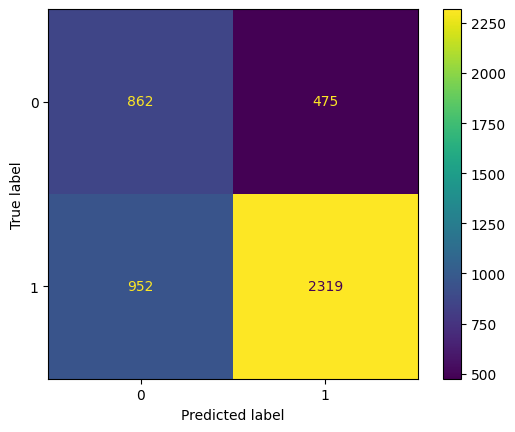

True Positives = 2319 
False Positives = 952 
False Negatives = 475 
True Negatives = 862


In [59]:
agent = soln_AbSCA.best_agent.copy()

validate_FS(train_features, train_labels, test_features, test_labels,val_features,val_labels, agent)